In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image

In [6]:
ds = load_dataset("pantelism/cats-vs-dogs")

In [4]:
class CatsVsDogsModel(nn.Module):
    def __init__(self):
        super(CatsVsDogsModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [7]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

#
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image'].convert("RGB")
        label = torch.tensor(self.dataset[idx]['label'], dtype=torch.float32)
       
        img = self.transform(img)
        return img, label


train_dataset = CustomDataset(ds['train'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [8]:
model = CatsVsDogsModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练函数
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [31]:
train_model(model, train_loader, criterion, optimizer)

Epoch [1/5], Loss: 0.6938
Epoch [2/5], Loss: 0.6925
Epoch [3/5], Loss: 0.6887
Epoch [4/5], Loss: 0.6802
Epoch [5/5], Loss: 0.6488


In [34]:
torch.save(model,"cnn.model")

In [32]:
train_model(model, train_loader, criterion, optimizer,15)

Epoch [1/15], Loss: 0.6147
Epoch [2/15], Loss: 0.5685
Epoch [3/15], Loss: 0.5091
Epoch [4/15], Loss: 0.4412
Epoch [5/15], Loss: 0.3754
Epoch [6/15], Loss: 0.2669
Epoch [7/15], Loss: 0.1584
Epoch [8/15], Loss: 0.0808
Epoch [9/15], Loss: 0.0473
Epoch [10/15], Loss: 0.0403
Epoch [11/15], Loss: 0.0384
Epoch [12/15], Loss: 0.0147
Epoch [13/15], Loss: 0.0026
Epoch [14/15], Loss: 0.0008
Epoch [15/15], Loss: 0.0003


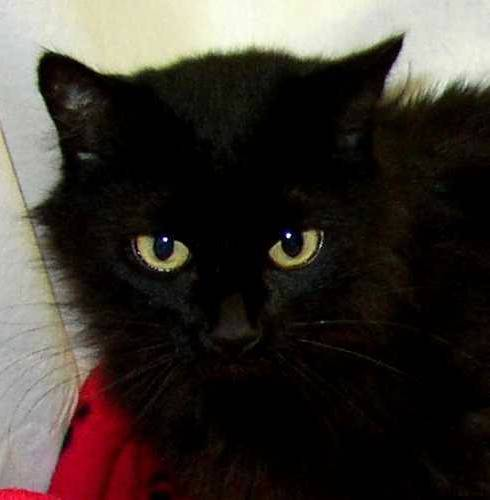

In [26]:
ds['train'][0]['image'].convert("RGB")

In [9]:
model = torch.load("cnn.model")

/tmp/ipykernel_1169/3469787903.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("cnn.model")


In [10]:

def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    # use zero tensor if baseline not spcified
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    model.eval()
    
    total_gradients = torch.zeros_like(input_tensor)
    
    for alpha in torch.linspace(0, 1, steps):

        interpolated_input = baseline + alpha * (input_tensor - baseline)
        interpolated_input.requires_grad_()
        
        #forward propagation
        output = model(interpolated_input)
        
        
        #backward propagation
        model.zero_grad()
        output.backward()
        
        #add up
        total_gradients += interpolated_input.grad
    
    #average
    avg_gradients = total_gradients / steps
    
    #apply the weight of input to overall average gradients
    integrated_gradients = (input_tensor - baseline) * avg_gradients
    
    return integrated_gradients

In [11]:
for images, labels in train_loader:
    images=images.to(device)
    labels=labels.to(device)
    images0=images[0].unsqueeze(0)
    print(model(images0))
    break

tensor([[0.0003]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [12]:
res=integrated_gradients(model,images0)

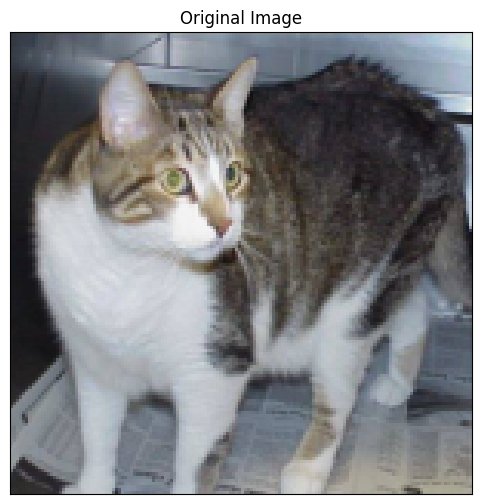

In [13]:
##some visualization using captum, code from https://www.youtube.com/watch?v=Am2EF9CLu-g&ab_channel=PyTorch

from captum.attr import visualization as viz
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

_ = viz.visualize_image_attr(None, np.transpose(images0.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")



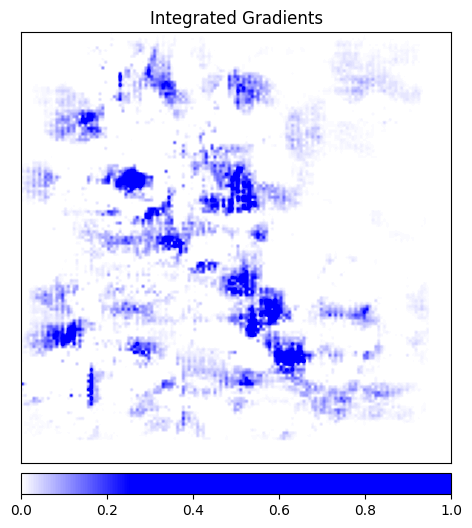

In [14]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(res.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(images0.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

End of Integrated gradients, it seems that the model do learn something about a cat according to the output of Ig algorithm, but some areas contribute too much and there exists some overfitting.

In [15]:
def grad_cam(model, input_tensor, target_layer):
    model.eval()
    
    activations = None
    gradients = None

    # hook api to get gradient of a layer
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
    
    # register hook
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    #forward propagation
    output = model(input_tensor)# binary classification only and we just use the raw output without searching for target class

    #backpropagation
    model.zero_grad()
    output.backward()

    #release hook ，though perhaps not necessary here
    handle_forward.remove()
    handle_backward.remove()

    #average pooling calculate weight on each channel
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    #get the heatmap, weighted sum of activation values on different channels. of which the weight being the gradients of channels
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    ##according to the demo notebook of Captum, it seems that captum is not normalizing the gradients, so I am not normalizing it here
    
    return heatmap

In [16]:
res = grad_cam(model,images0,model.conv4)

/home/wzy/CS6613-zw4759/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


/home/wzy/CS6613-zw4759/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


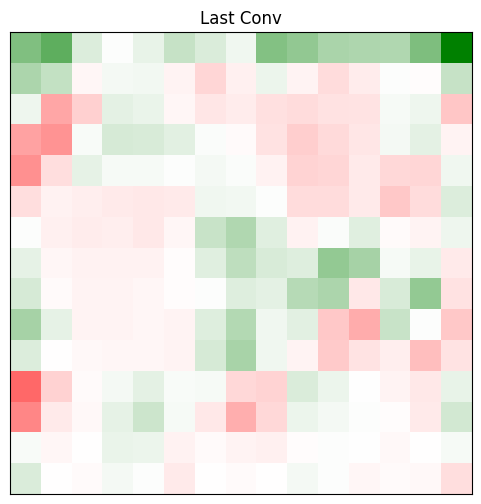

In [17]:
_ = viz.visualize_image_attr(res.cpu().unsqueeze(0).permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Last Conv")

torch.Size([1, 1, 150, 150])
torch.Size([1, 3, 150, 150])


/home/wzy/CS6613-zw4759/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(
/home/wzy/CS6613-zw4759/.venv/lib/python3.11/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


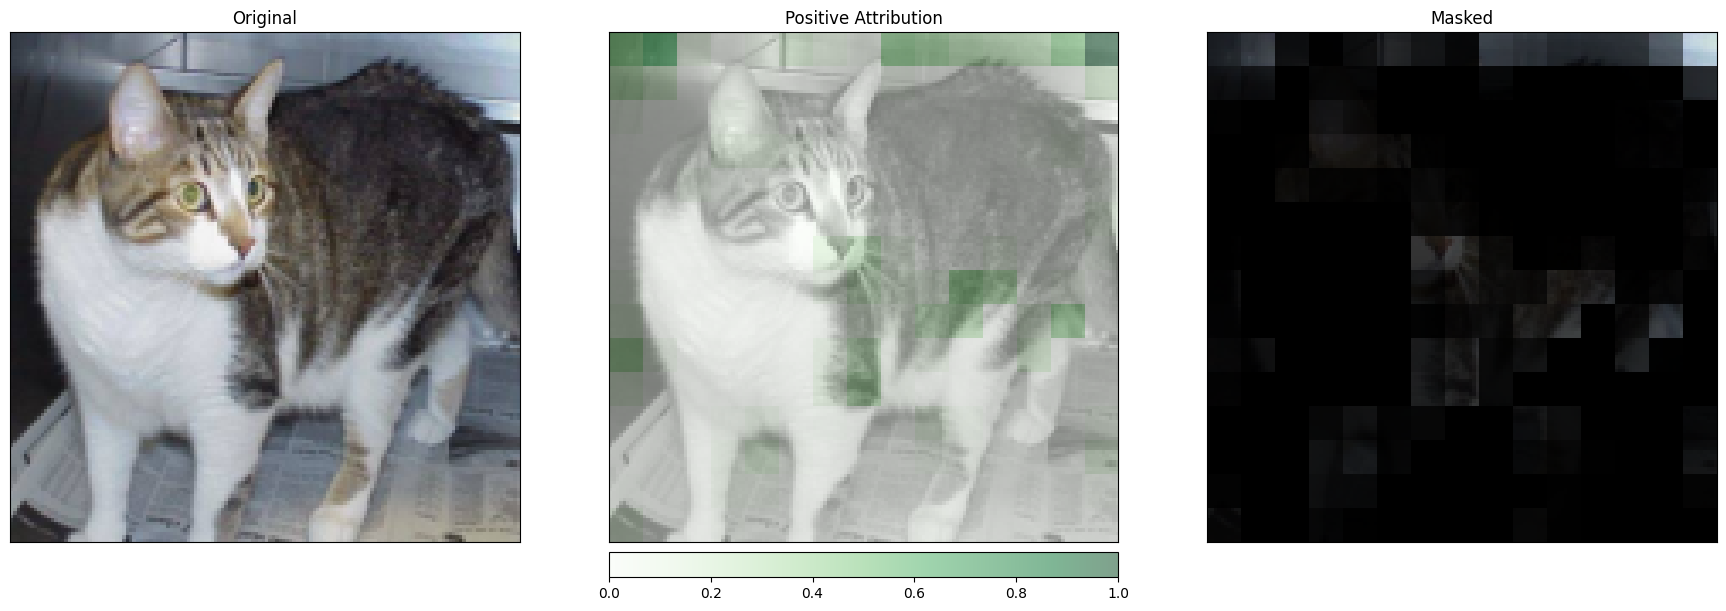

In [19]:
from captum.attr import LayerAttribution

upsamp_attr_lgc = LayerAttribution.interpolate(res.cpu().unsqueeze(0).unsqueeze(0), images0.shape[2:])

print(upsamp_attr_lgc.shape)
print(images0.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      images0.cpu().squeeze().permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))